## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/17_features.csv')


print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1269, 17)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,medication,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,11,6,1.0,0.0,30.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8,1,1.0,0.0,30.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,1.0,8,5,1.0,23.0,30.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,11,9,1.0,2.0,30.0,0.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,11,6,1.0,0.0,4.0,0.0,26.0,2.0,1.0


In [3]:
X, y = data.drop(columns=['dropout']), data['dropout']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1015, 16)
Shape of X_test: (254, 16)


Train C-Index: 0.8438623583456172
Test C-Index: 0.7364116915422886


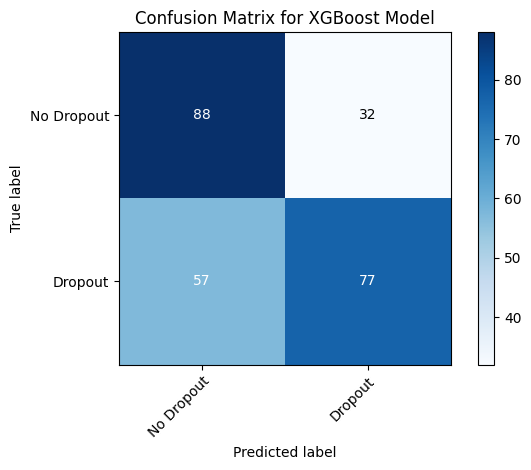

In [4]:
# fit the data to xgb classifier
xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, random_state=42)

# fit the model
xgb.fit(X_train, y_train)

# get the probability scores
y_train_probs = xgb.predict_proba(X_train)[:, 1]
y_test_probs = xgb.predict_proba(X_test)[:, 1]

# convert the probabilities to binary
y_train_preds = (y_train_probs > 0.5).astype(int)
y_test_preds = (y_test_probs > 0.5).astype(int)

# calculate the c-index
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_probs)}")
print(f"Test C-Index: {helper.cindex(y_test.values, y_test_probs)}")

# plot the confusion matrix
helper.plot_confusion_matrix(y_test, y_test_preds, ['No Dropout', 'Dropout'], title='Confusion Matrix for XGBoost Model');

In [5]:
import shap

ex = shap.Explainer(xgb.predict_proba, X_train, max_evals=700)
shap_values = ex(X_test)

PermutationExplainer explainer: 255it [00:16,  6.74it/s]                         


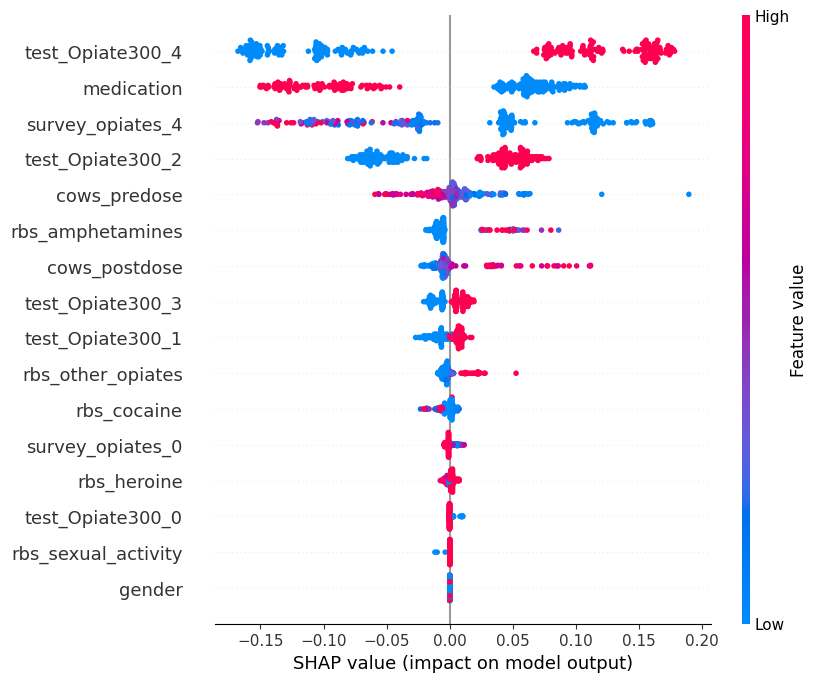

In [6]:
# beeswarm plot
shap.plots.beeswarm(shap_values[:,:,1], max_display=17, show=True)

## Look for Interactions - Self Reported Use with Opiate Tests

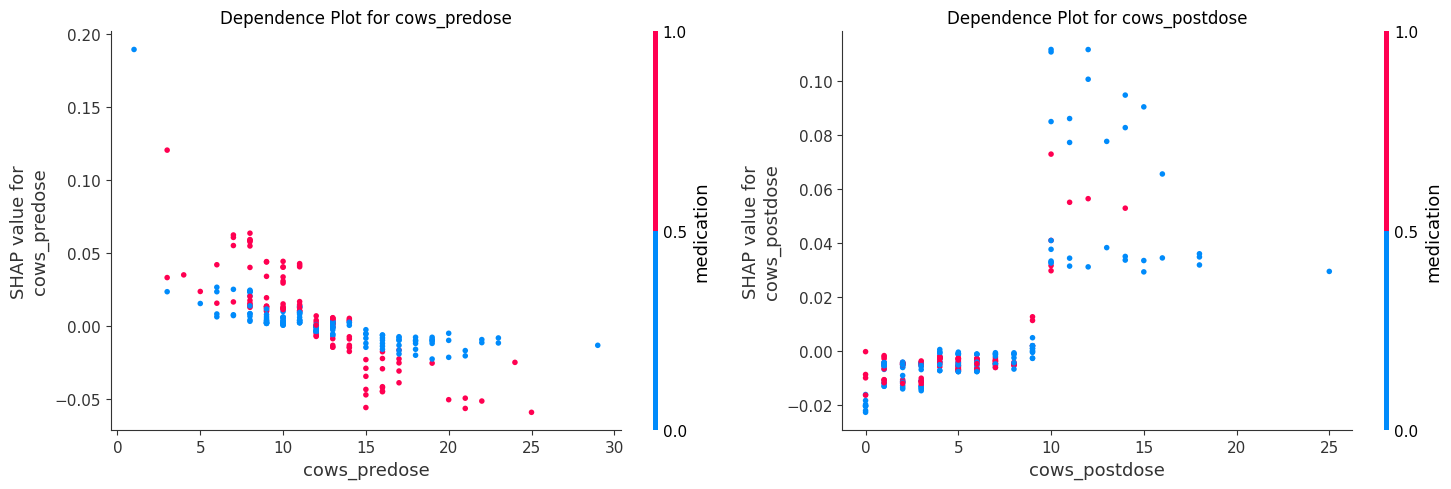

In [7]:
# define features for comparison

# interaction 1
feature1 = 'cows_predose'
feature2 = 'medication'

# interaction 2
feature3 = 'cows_postdose'
feature4 = 'medication'

shap_values_array = shap_values.values

# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


## Look for Interactions - Self Reported Use with Opiate Tests

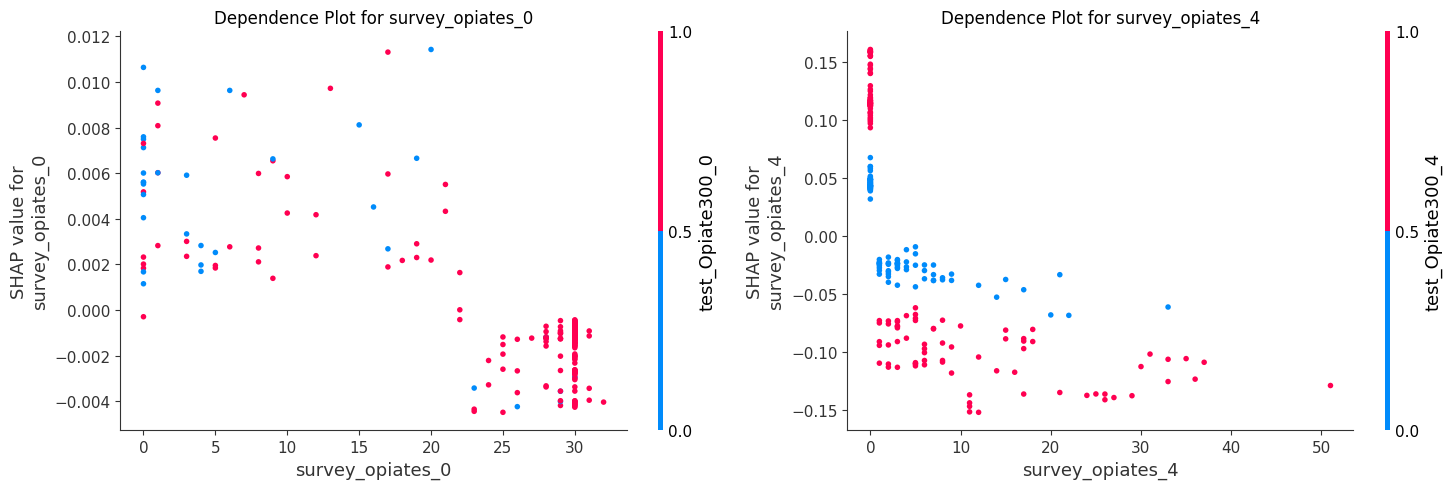

In [8]:
# define features for comparison

# interaction 1
feature1 = 'survey_opiates_0'
feature2 = 'test_Opiate300_0'

# interaction 2
feature3 = 'survey_opiates_4'
feature4 = 'test_Opiate300_4'

shap_values_array = shap_values.values

# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


Class index: 1
Data index: 4


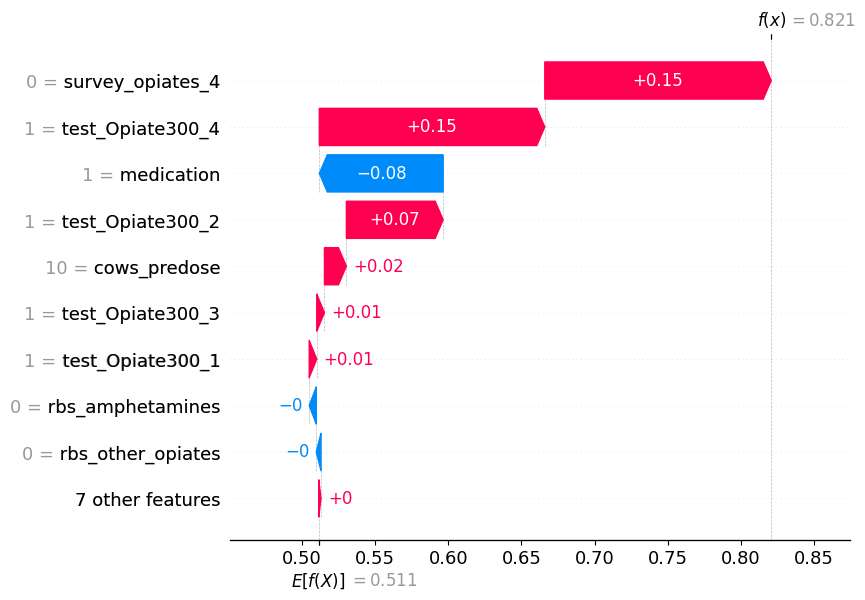

In [9]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[data_index,:,class_index])

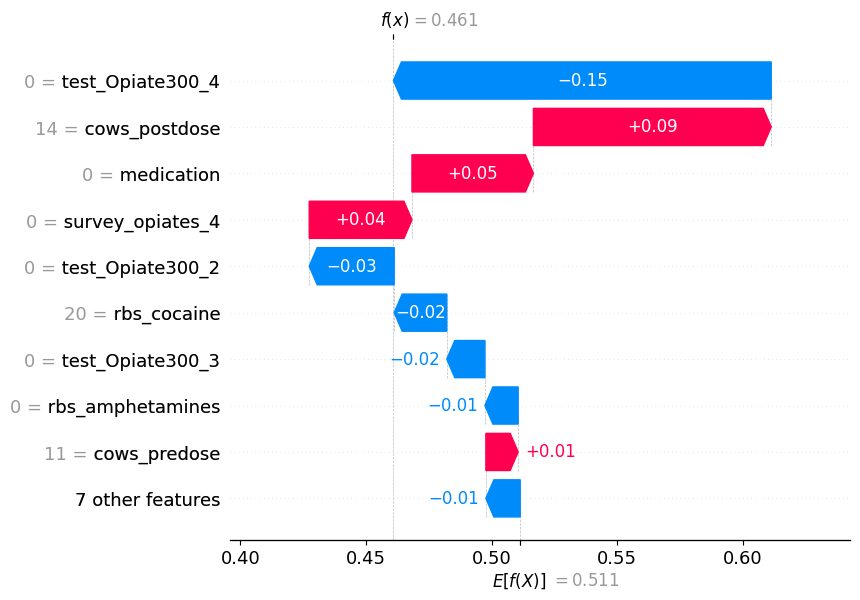

In [10]:
shap.plots.waterfall(shap_values[50,:,1])

Class index: 1
Data index: 207


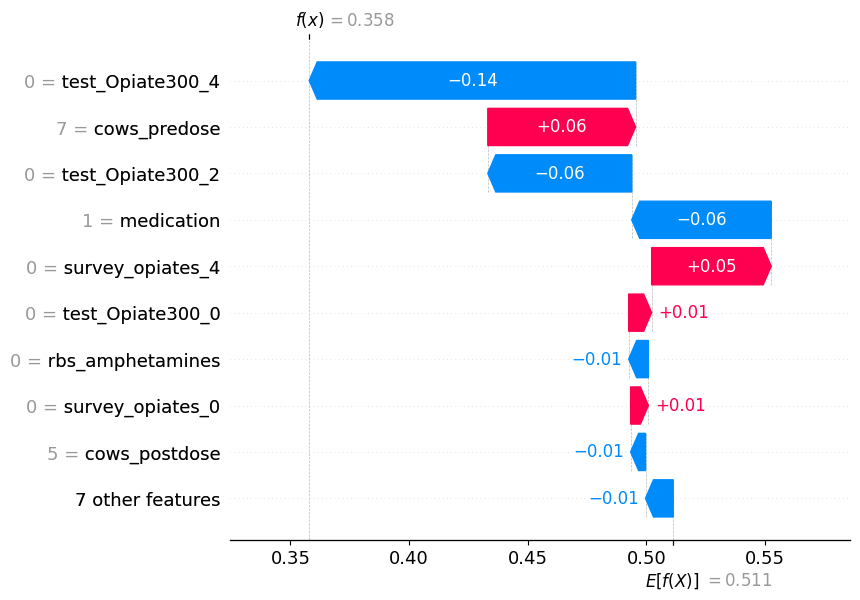

In [11]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[data_index,:,class_index])

Class index: 1
Data index: 228


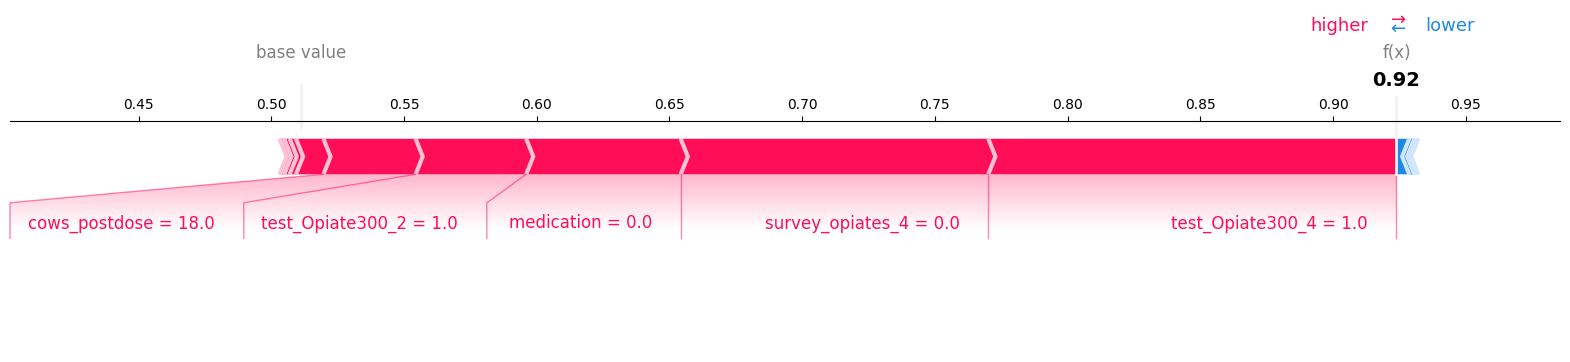

In [13]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True, show=True)